In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = '../models'
subDir = 'ionosphere'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 500 # number of epochs
BATCH_SIZE = 16
ALPHA = 0.001 # learning rate
TRAIN_SIZE = int(17*BATCH_SIZE) # complete batches

WEIGHT_DECAY = 0.001
PATIENCE = 30
LR_FACTOR = 0.1
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.brg

plt.rcParams.update(params)

## Read MNIST FASHION data set

In [4]:
trainFilepath = os.path.join(inpDir, subDir, 'ionosphere.data')


data_df = pd.read_csv(trainFilepath, header = None)

data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


## All about CUDA

In [5]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

Is CUDA available:  False
CUDA version:  None


In [6]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [7]:
data_df.shape  

(351, 35)

In [8]:
# to check in what ratio to split data
print(351*0.18/16)
print(351 -17 * 16)

# changed batch size to 16 after this calculation and also changed train_size

3.94875
79


In [9]:
train_df , test_df = train_test_split(data_df, 
                                      train_size = TRAIN_SIZE, 
                                      stratify = data_df[data_df.columns[-1]]) 
train_df.shape, test_df.shape

((272, 35), (79, 35))

In [10]:
'''Using Singleton design pattern'''

class Transformers:
    '''
    Args :
         has one standard scaler and one label encoder
    '''
    _instance = None
    
    def __init__ (self):
        if Transformers._instance is not None:
            raise Exception ("GlobalScaler class is a singleton.")

        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()
        
    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = Transformers()
        return cls._instance
    

In [11]:
'''
In this code, we define a custom dataset called IonoDS that takes a DataFrame as input. 

'''
class IonoDS(Dataset):

    transformers = Transformers.get_instance()    #scaler and encoder
    
    def __init__(self, 
                 dataframe: pd.DataFrame, 
                 device : str = device,
                 is_train = True,
                 label_col = None
                ):
        super(IonoDS, self).__init__()
        
        self.df = dataframe
        self.device = device
        self.is_train = is_train
        self.label_col = label_col
        self.scaler = self.transformers.scaler
        self.encoder = self.transformers.encoder

        
        y = self.df[self.label_col].to_numpy()
        X = self.df.drop(self.label_col, axis = 1).to_numpy()
        
        
        if self.is_train:
            self.labels = self.encoder.fit_transform(y)
            self.features = self.scaler.fit_transform(X)
        else :
            self.labels = self.encoder.transform(y)
            self.features = self.scaler.transform(X)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, 
                                dtype=torch.float32, 
                                device=self.device)
        
        label = torch.tensor(label, 
                             dtype=torch.int64, 
                             device=self.device)
        
        return features, label

In [12]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()

        # define Dropout rates
        self.dor1 = 0.5
        self.dor2 = 0.1
        self.dor3 = 0.15

        # Layer 1 
        self.layer1 = nn.Linear(input_dim,26) # 34 x 26
        self.bn1 = nn.BatchNorm1d(26)
        self.activ1 = nn.ReLU()
        self.dropout1 = nn.Dropout(self.dor1)


        # Layer 2
        self.layer2 = nn.Linear(26, 18)   # 26 x 18
        self.bn2 = nn.BatchNorm1d(18)
        self.activ2 = nn.ReLU()
        self.dropout2 = nn.Dropout(self.dor2)

        # Layer 3
        self.layer3 = nn.Linear(18, 10)  # 18 x 10
        self.bn3 = nn.BatchNorm1d(10)
        self.activ3 = nn.ReLU()
        self.dropout3 = nn.Dropout(self.dor3)

        #Layer 4
        self.layer4 = nn.Linear(10, 2)  # 10 x 2
        self.softmax = nn.LogSoftmax(dim = 1)
         
    def forward(self, x):

        # x = self.dropout1(self.activ1(self.bn1))   -->different way to write 
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.activ2(x)
        x = self.dropout2(x)
        
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.activ3(x)
        x = self.dropout3(x)

        x = self.layer4(x)
        
        return self.softmax(x)



In [13]:
input_shape = 34
net = Model(input_dim=input_shape).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=34, out_features=26, bias=True)
  (bn1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=26, out_features=18, bias=True)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (layer3): Linear(in_features=18, out_features=10, bias=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ3): ReLU()
  (dropout3): Dropout(p=0.15, inplace=False)
  (layer4): Linear(in_features=10, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [14]:
label_col = 34
train_ds = IonoDS(train_df, is_train= True, label_col=label_col)
test_ds = IonoDS(test_df, is_train= False, label_col=label_col)

In [15]:
train_loader = DataLoader(train_ds, 
                         batch_size = BATCH_SIZE,
                         shuffle= True)
test_loader = DataLoader(test_ds, 
                         batch_size = BATCH_SIZE,
                         shuffle= True)

In [16]:
XX, yy = next(iter(train_loader))

In [17]:
train_ds

In [18]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), 
                             lr=ALPHA, 
                             weight_decay=1e-5) # weight decay

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                      factor=LR_FACTOR,
                                                      patience=LR_PATIENCE,
                                                      min_lr=0.00001)

minLoss = float('inf') #minimum loss
savePath = os.path.join('models', 'iono.pth')

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        net.eval()
        #net.train()
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)

    scheduler.step(test_loss)

    # Add Early stopping / saving model
    if test_loss < minLoss :
        minLoss  = test_loss
        counter = 0
        #save the model
        torch.save({'epoch': epoch + 1,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_fn}, savePath)
    else :
        counter += 1
        
    if counter > PATIENCE :
        break
    
   
    print(f' At epoch {epoch : 3d} ', end = '')
    print(f'| Loss : {train_loss:.4f}/{test_loss:.4f}', end = '')
    print(f'| Acc : {train_acc:.4f}/{test_acc:.4f}', end = '')
    print(f'| LR : {scheduler.get_last_lr()[0]:.5f}', end = '')
    print(f'| Counter : {counter}')


 At epoch   0 | Loss : 0.7576/0.6216| Acc : 0.5221/0.7468| LR : 0.00100| Counter : 0
 At epoch   1 | Loss : 0.6134/0.5662| Acc : 0.7132/0.7848| LR : 0.00100| Counter : 0
 At epoch   2 | Loss : 0.5473/0.4878| Acc : 0.7757/0.8481| LR : 0.00100| Counter : 0
 At epoch   3 | Loss : 0.4644/0.4039| Acc : 0.8346/0.8987| LR : 0.00100| Counter : 0
 At epoch   4 | Loss : 0.3753/0.3220| Acc : 0.9007/0.9114| LR : 0.00100| Counter : 0
 At epoch   5 | Loss : 0.2947/0.2565| Acc : 0.9265/0.9114| LR : 0.00100| Counter : 0
 At epoch   6 | Loss : 0.2350/0.2187| Acc : 0.9375/0.9367| LR : 0.00100| Counter : 0
 At epoch   7 | Loss : 0.1936/0.1960| Acc : 0.9485/0.9494| LR : 0.00100| Counter : 0
 At epoch   8 | Loss : 0.1655/0.1844| Acc : 0.9522/0.9494| LR : 0.00100| Counter : 0
 At epoch   9 | Loss : 0.1421/0.1731| Acc : 0.9632/0.9494| LR : 0.00100| Counter : 0
 At epoch  10 | Loss : 0.1219/0.1631| Acc : 0.9632/0.9494| LR : 0.00100| Counter : 0
 At epoch  11 | Loss : 0.1096/0.1569| Acc : 0.9669/0.9494| LR : 0

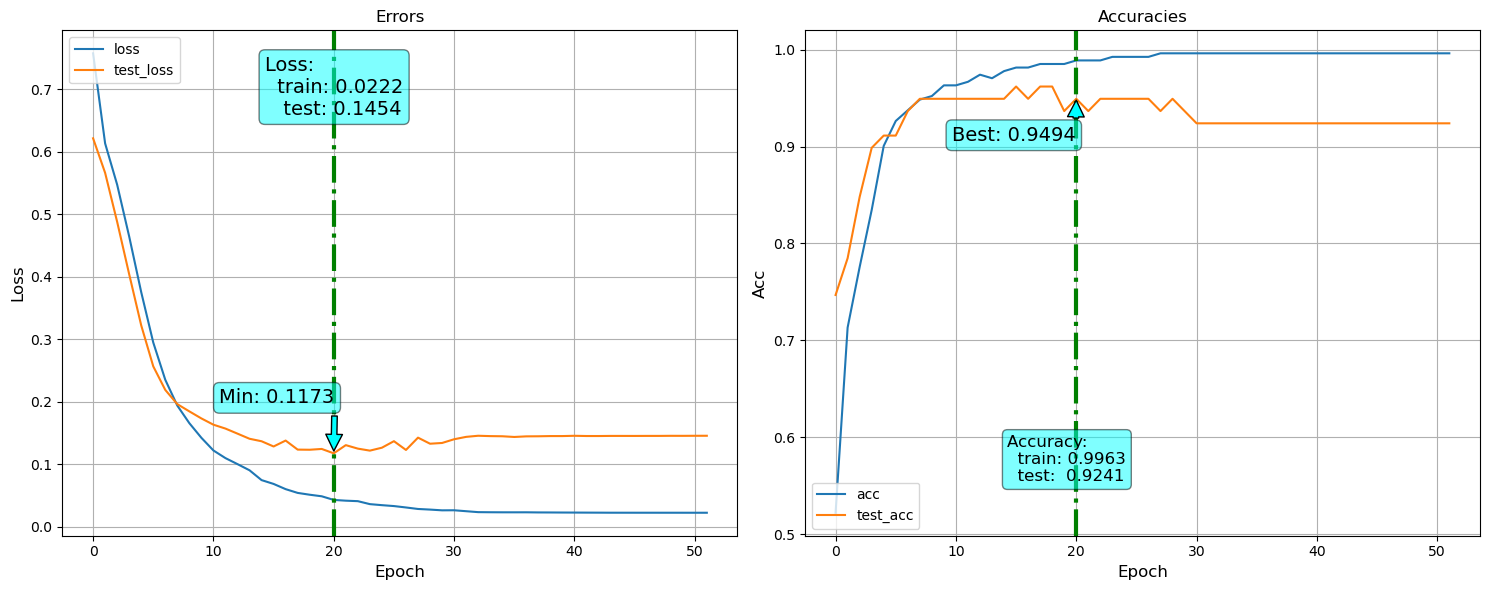

In [19]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
fn_plot_torch_hist(loss_df)

In [20]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [21]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       0.99      1.00      1.00       174

    accuracy                           1.00       272
   macro avg       1.00      0.99      1.00       272
weighted avg       1.00      1.00      1.00       272



In [22]:
class_labels = {k:v for k, v in enumerate(train_ds.transformers.encoder.classes_)}

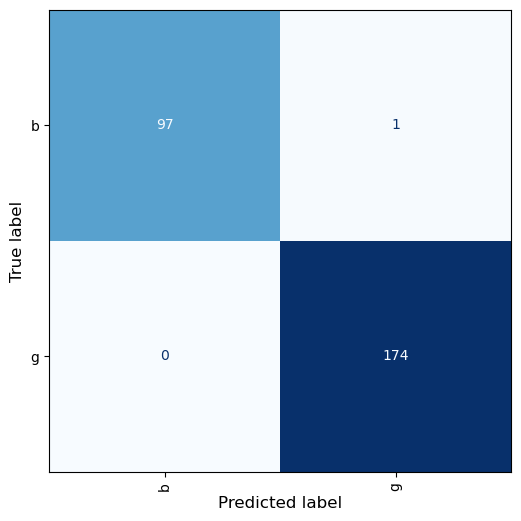

In [23]:
fn_plot_confusion_matrix(y_train, y_pred, class_labels)